In [1]:
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession
from pyspark.sql import functions as f
from pyspark.sql.types import *

In [2]:
!hdfs dfsadmin -safemode leave

Safe mode is OFF


In [8]:
#!hdfs fs -rm -r ml-latest-small
!hdfs dfs -put ml-latest-small /

In [9]:
conf = SparkConf()\
    .set("spark.executor.instances", "2")\
    .set("spark.executor.cores", "1")\
    .set("spark.executor.memory", "1g")

In [11]:
spark = SparkSession.builder.appName("Svirin_spark").config(conf=conf).master(master="yarn").getOrCreate()

Block1:

Приложить скрин YARN-а, где запущено приложение, приложить скрин UI приложения spark

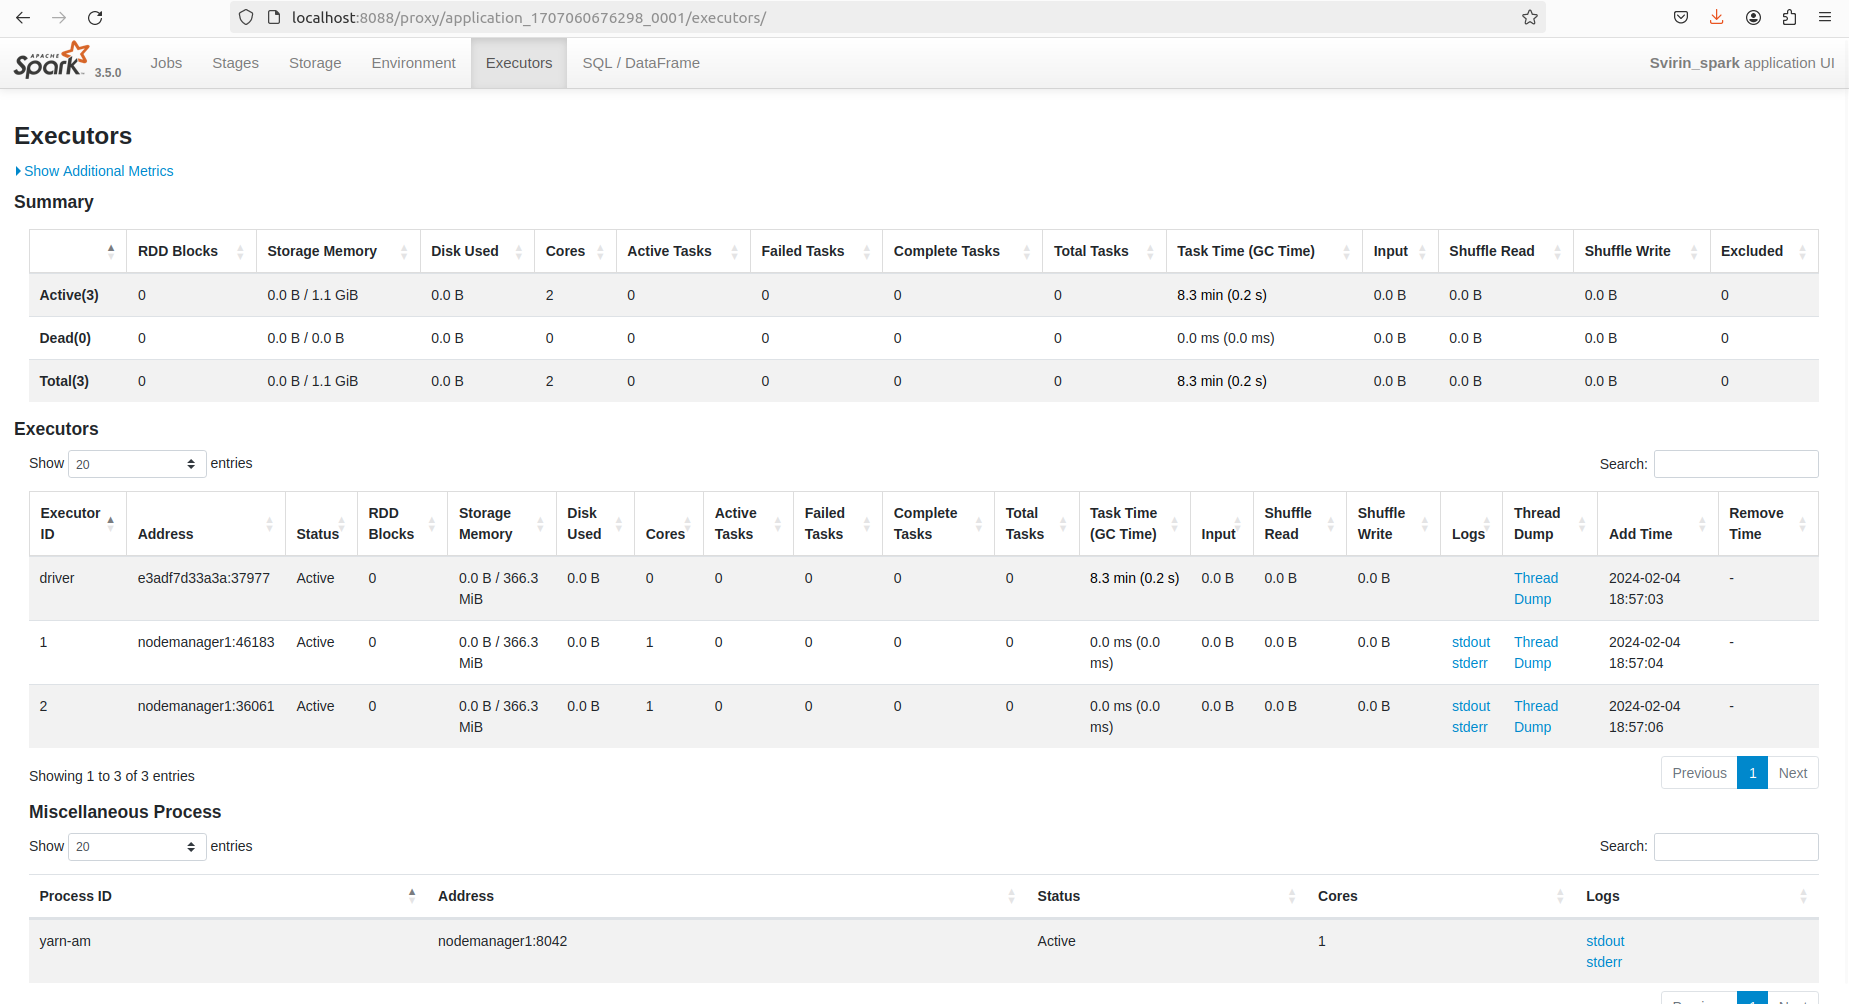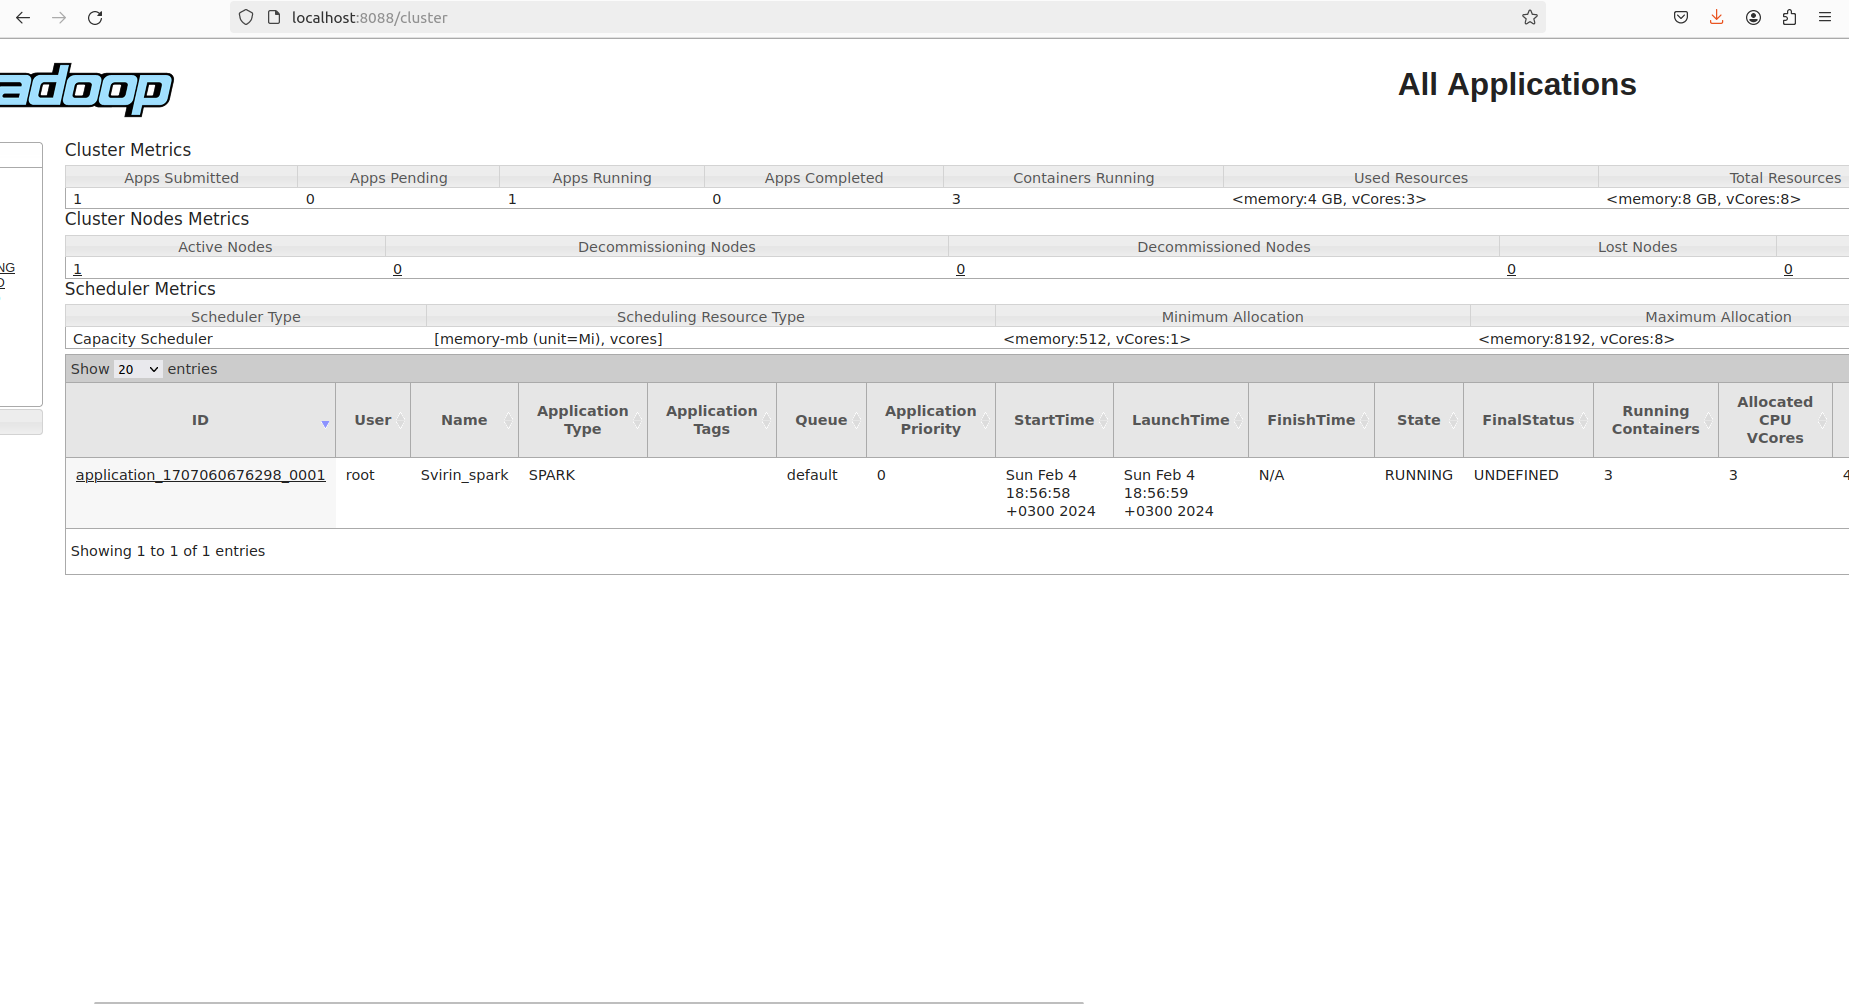

Прочитать таблицы ratings, tags в директории ml-latest-small; отобразить количество строчек и в том, и в другом датасете.

In [12]:
ratings_schema = StructType(fields=[
    StructField("userId", IntegerType()),
    StructField("movieId", IntegerType()),
    StructField("rating", DoubleType()),
    StructField("timestamp", LongType()),
])

tags_schema = StructType(fields=[
    StructField("userId", IntegerType()),
    StructField("movieId", IntegerType()),
    StructField("tag", StringType()),
    StructField("timestamp", LongType()),
])

In [23]:
%%time
ratings_df = spark\
    .read\
    .format("csv")\
    .option("header", "True")\
    .schema(ratings_schema)\
    .load("/ml-latest-small/ratings.csv")

CPU times: user 2.09 ms, sys: 0 ns, total: 2.09 ms
Wall time: 17.2 ms


In [24]:
%%time
tags_df = spark\
    .read\
    .format("csv")\
    .option("header", "True")\
    .schema(tags_schema)\
    .load("/ml-latest-small/tags.csv")

CPU times: user 1.55 ms, sys: 1.45 ms, total: 2.99 ms
Wall time: 15.8 ms


In [25]:
ratings_df.count()

100836

In [26]:
tags_df.count() 

3683

Приложить скрин spark-ui с выполненной job-ой (можно приложить прям в markdown ячейки, можно положить в той же папке, что и ноутбук). Написать, сколько было выполнено стейджей и тасок.

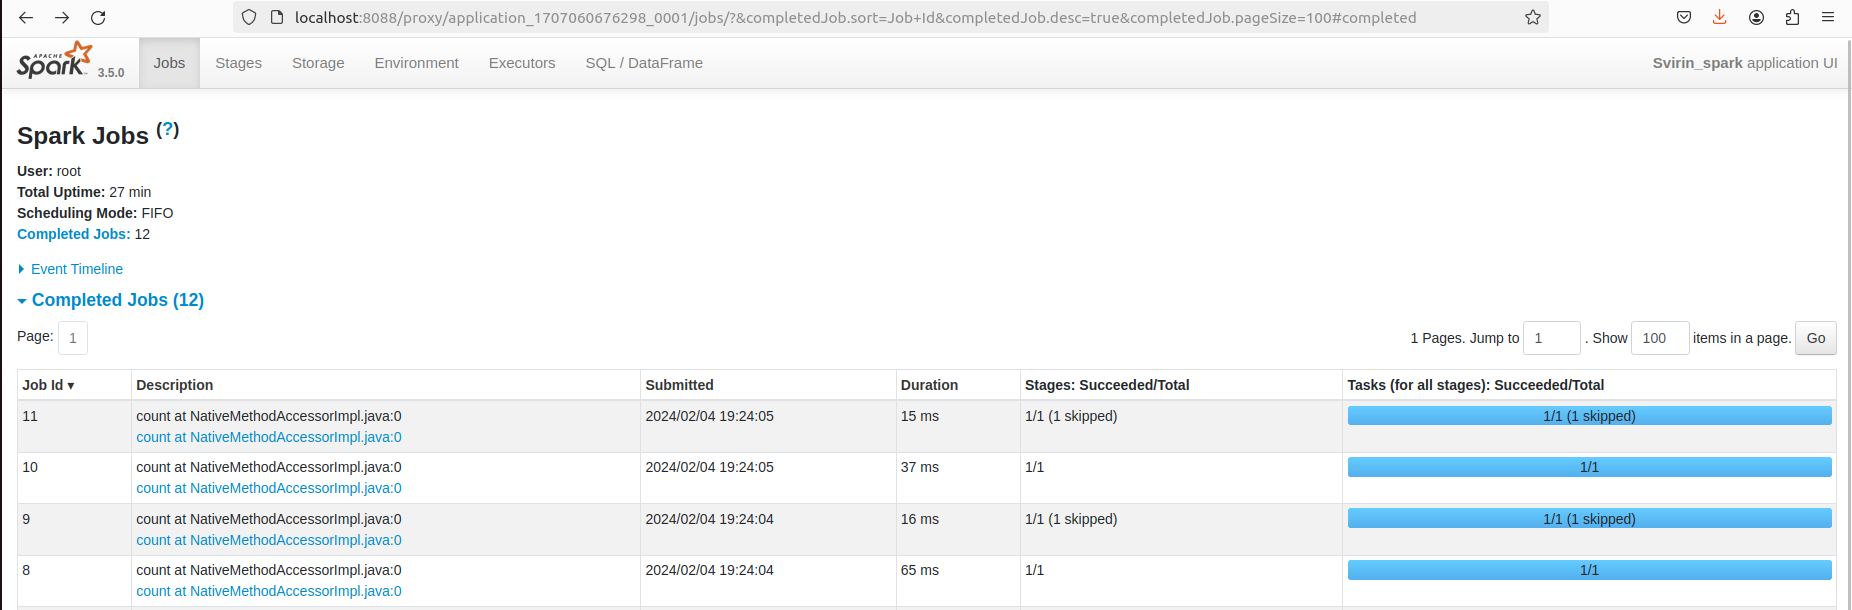

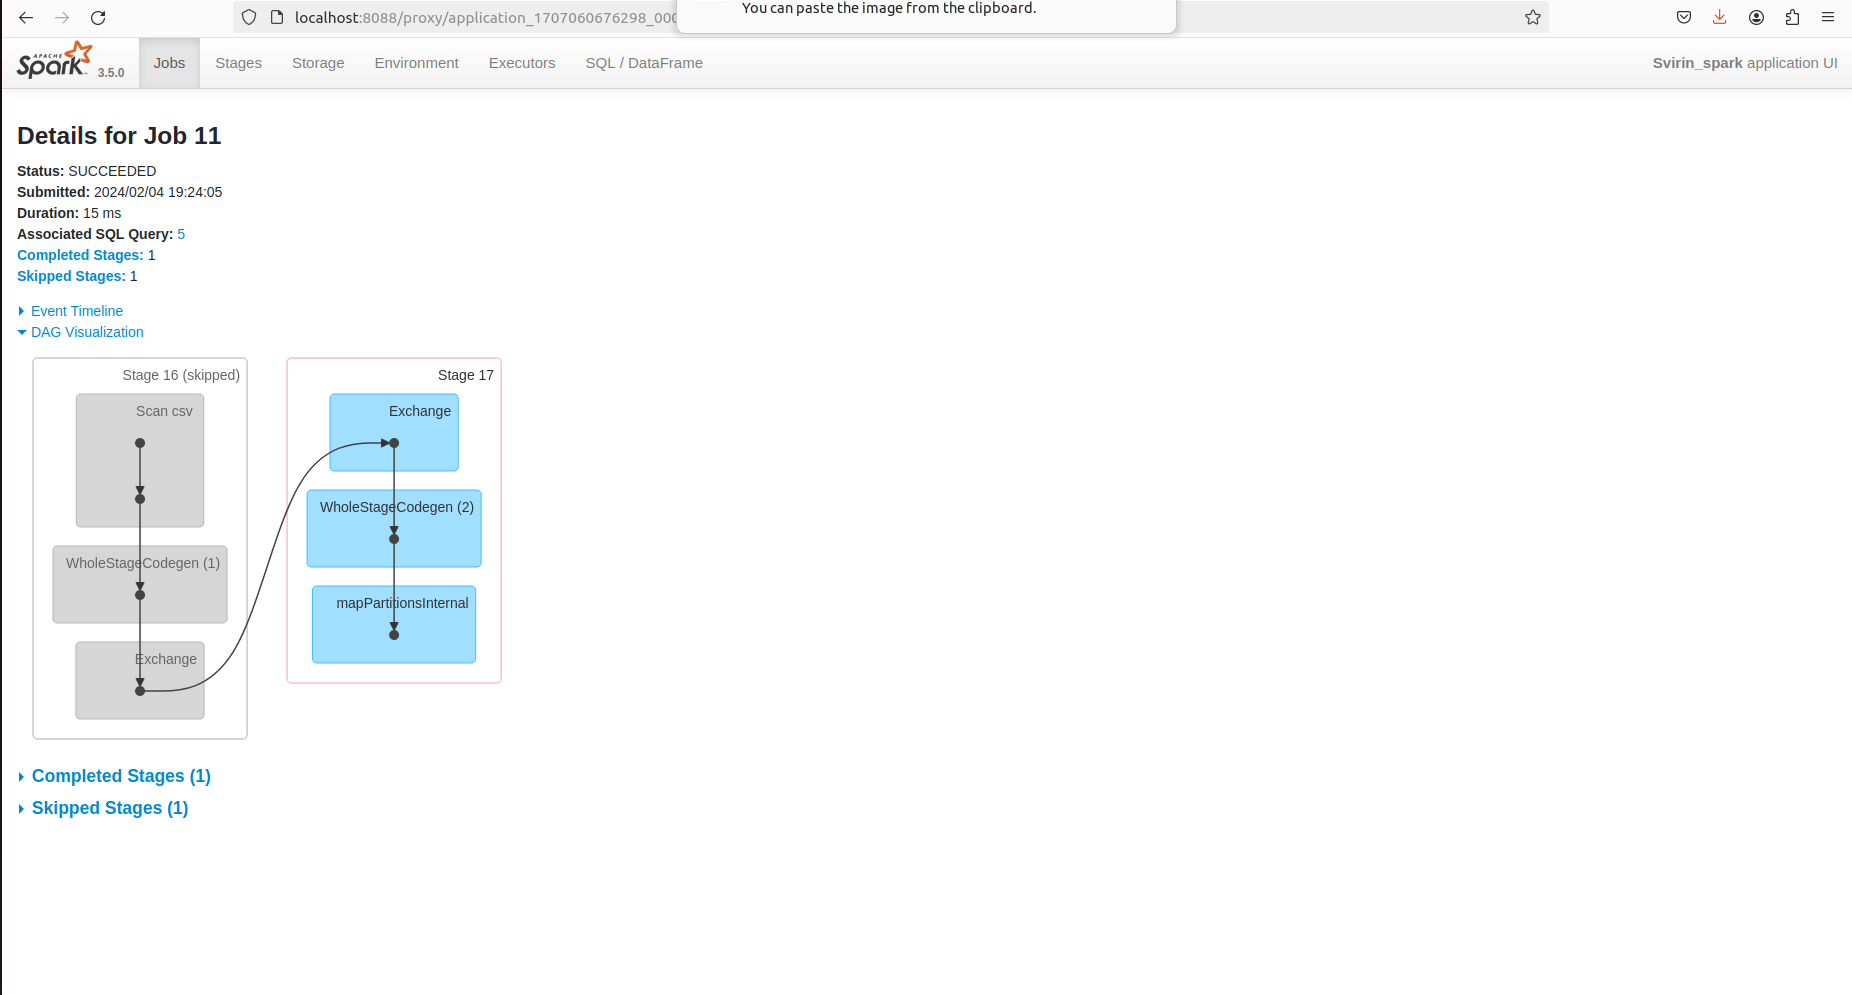

Выполнено 2 стейджа, 2 таски.

Block2:

1) Посчитать количество уникальных фильмов и уникальных юзеров в таблице “ratings”.

In [29]:
ratings_df.select("movieId").distinct().count()

9724

In [30]:
ratings_df.select("userId").distinct().count()

610

2) Посчитать, сколько было поставлено оценок >= 4.0. 

In [31]:
ratings_df.filter(4 <= ratings_df["rating"]).count()

48580

3) Вывести топ100 фильмов с самым высоким рейтингом.

In [34]:
ratings_df.groupBy("movieId").agg(f.avg("rating").alias("average_rating")).orderBy(f.desc("average_rating")).take(100)

[Row(movieId=2196, average_rating=5.0),
 Row(movieId=88448, average_rating=5.0),
 Row(movieId=172909, average_rating=5.0),
 Row(movieId=67618, average_rating=5.0),
 Row(movieId=3496, average_rating=5.0),
 Row(movieId=148, average_rating=5.0),
 Row(movieId=142444, average_rating=5.0),
 Row(movieId=496, average_rating=5.0),
 Row(movieId=8911, average_rating=5.0),
 Row(movieId=118834, average_rating=5.0),
 Row(movieId=173963, average_rating=5.0),
 Row(movieId=156025, average_rating=5.0),
 Row(movieId=5513, average_rating=5.0),
 Row(movieId=120130, average_rating=5.0),
 Row(movieId=26350, average_rating=5.0),
 Row(movieId=1349, average_rating=5.0),
 Row(movieId=147300, average_rating=5.0),
 Row(movieId=122092, average_rating=5.0),
 Row(movieId=633, average_rating=5.0),
 Row(movieId=71268, average_rating=5.0),
 Row(movieId=876, average_rating=5.0),
 Row(movieId=99636, average_rating=5.0),
 Row(movieId=53578, average_rating=5.0),
 Row(movieId=6086, average_rating=5.0),
 Row(movieId=160644, a

4) Посчитать разницу во времени в секундах между временем тегирования пользователя данного фильма и временем, когда пользователь поставил оценку фильму. В качестве ответа выведете среднюю дельту по времени.

In [39]:
joined = ratings_df.withColumnRenamed("timestamp", "ratings_timestamp").join(tags_df, on=['userId', 'movieId'])
time_diff = joined.withColumn("time_diff", f.col("timestamp") -  f.col("ratings_timestamp"))
#в секундах
print(time_diff.agg(f.mean('time_diff')).collect()[0][0]  / 1000)

26243.727372266974


5. Посчитать среднюю оценку от каждого пользователя, в качестве ответа выведете среднее от всех усредненных оценок всех пользователей. (7 баллов)

In [40]:
ans = ratings_df.groupBy("userId").agg(f.avg("rating").alias("average_by_user")).agg(f.avg("average_by_user"))

In [42]:
ans.collect()[0][0]

3.6572223377474016

Block3:

Обучите модель предсказания оценок по тегам
с помощью TfidfVectorizer и SGDRegressor из модуля scikit-learn - тут уже можно сконвертировать два датасета в
pandas через .toPandas

In [187]:
rating_tag = joined.toPandas()

In [188]:
rating_tag_spark = joined

In [189]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDRegressor
import pandas as pd

сначала  TfidfVectorizer обучаете на колонке “tag”
получаете численные признаки transform-ом от tfidf на той же колонке “tag”

In [190]:
tfidf_vectorizer = TfidfVectorizer()
transformed = tfidf_vectorizer.fit_transform(rating_tag["tag"])

обучаете SGDRegressor на новых численных признаках от  TfidfVectorizer-а с лейблом “rating”


In [191]:
sgd_regressor = SGDRegressor()
sgd_regressor.fit(transformed, rating_tag["rating"])

SGDRegressor()

Напишите UDF, которая делает предсказание рейтинга по столбцу “tag”

In [192]:
@f.pandas_udf(DoubleType())
def predict(tags):
    transformed = tfidf_vectorizer.transform(tags)
    return pd.Series(sgd_regressor.predict(transformed))

In [194]:
data_predictions = rating_tag_spark.withColumn("predicted", predict(f.col("tag")))

In [195]:
data_predictions.show(50)

+------+-------+------+-----------------+--------------------+----------+------------------+
|userId|movieId|rating|ratings_timestamp|                 tag| timestamp|         predicted|
+------+-------+------+-----------------+--------------------+----------+------------------+
|     2|  60756|   5.0|       1445714980|        will ferrell|1445714992| 4.031358043222962|
|     2|  60756|   5.0|       1445714980|     Highly quotable|1445714996|  3.94385898286867|
|     2|  60756|   5.0|       1445714980|               funny|1445714994| 4.365808456735981|
|     2|  89774|   5.0|       1445715189|           Tom Hardy|1445715205| 3.837747006072692|
|     2|  89774|   5.0|       1445715189|                 MMA|1445715200| 3.424174542945441|
|     2|  89774|   5.0|       1445715189|        Boxing story|1445715207|3.9313624768198143|
|     2| 106782|   5.0|       1445714966|     Martin Scorsese|1445715056| 3.846629778646602|
|     2| 106782|   5.0|       1445714966|   Leonardo DiCaprio|14457150

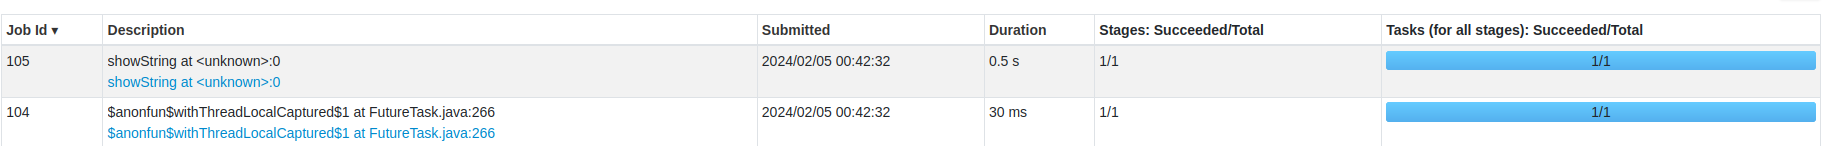

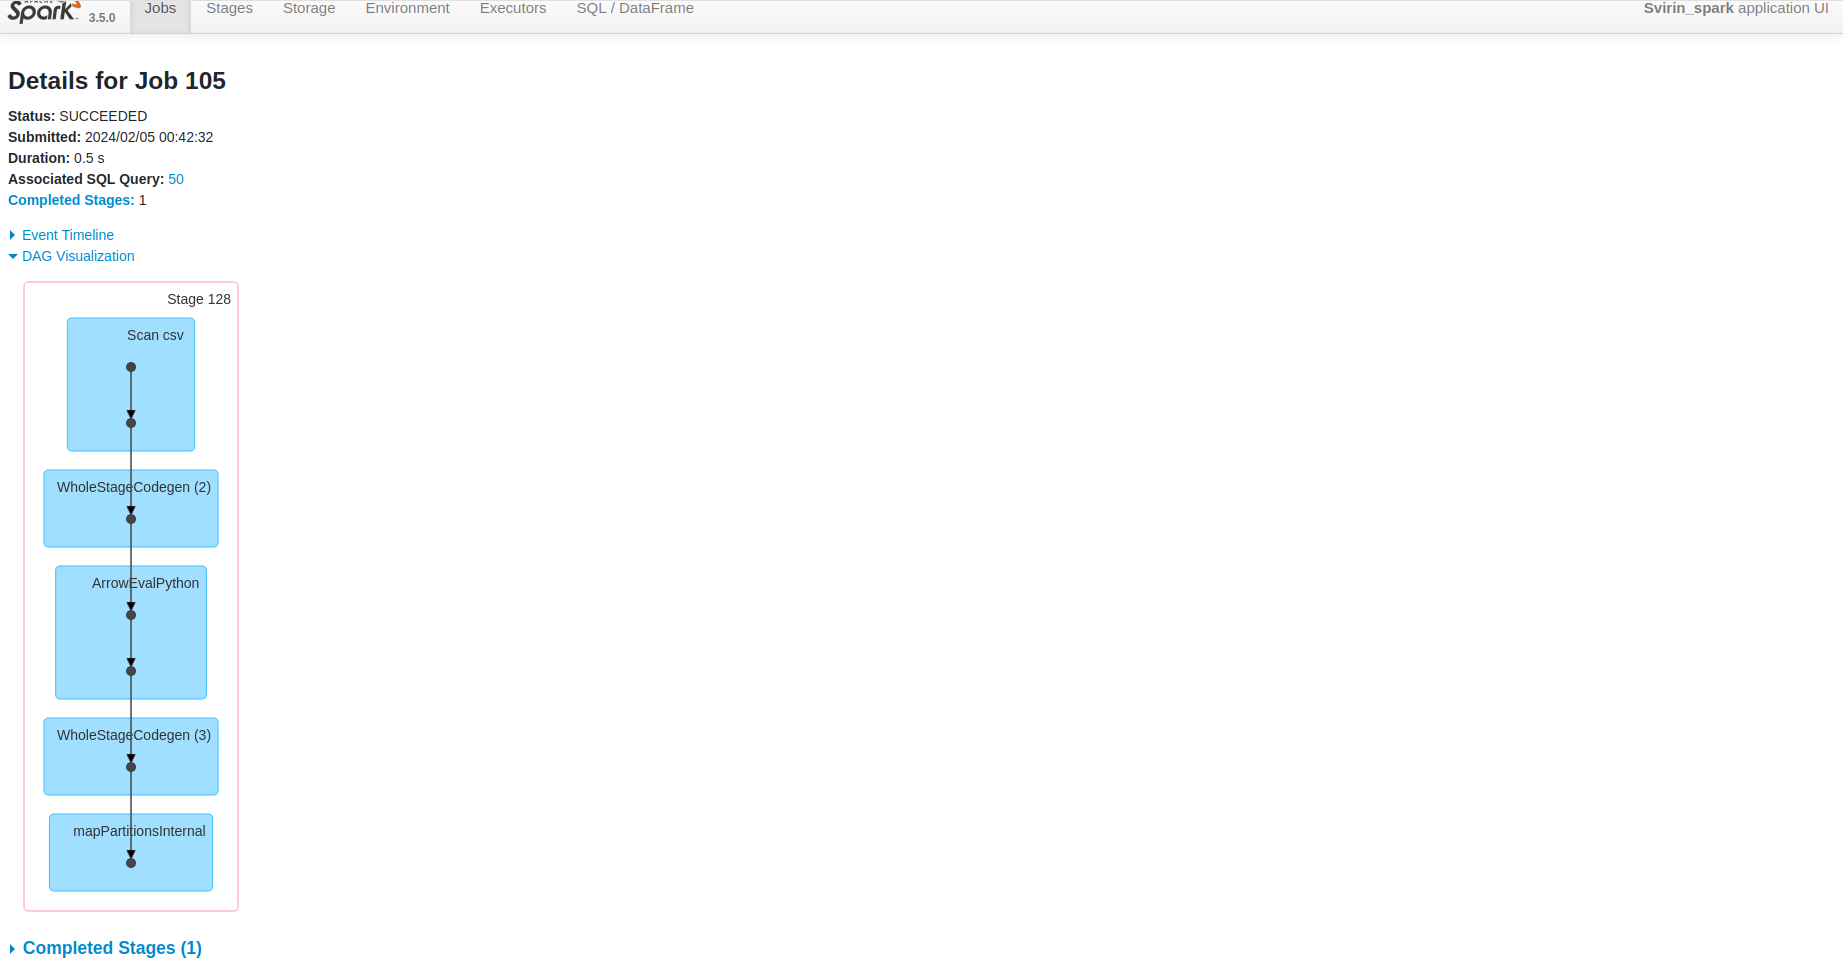

In [ ]:
2 джобы 2 стейджа

Напишите, чему равен корень суммы квадратов разностей (RMSE) 

In [196]:
diffs = data_predictions.select(((f.col("rating") - f.col("predicted")) ** 2).alias("diffs"))
rmse = diffs.select(f.sqrt(f.avg(f.col("diffs"))))
rmse.show()

+------------------+
|  SQRT(avg(diffs))|
+------------------+
|0.8743855824315527|
+------------------+



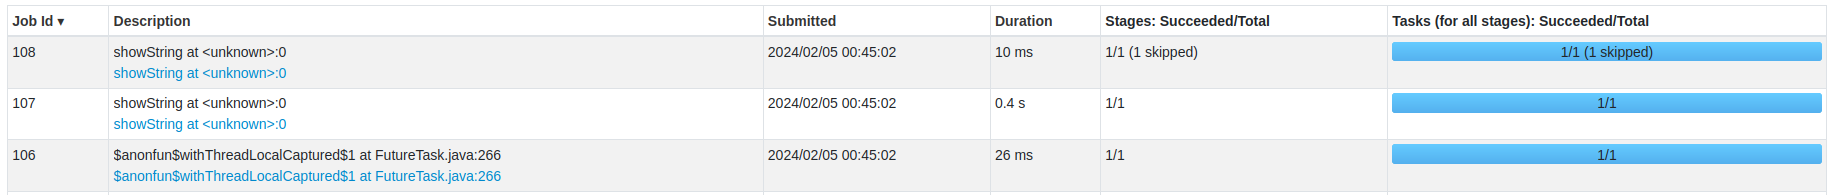

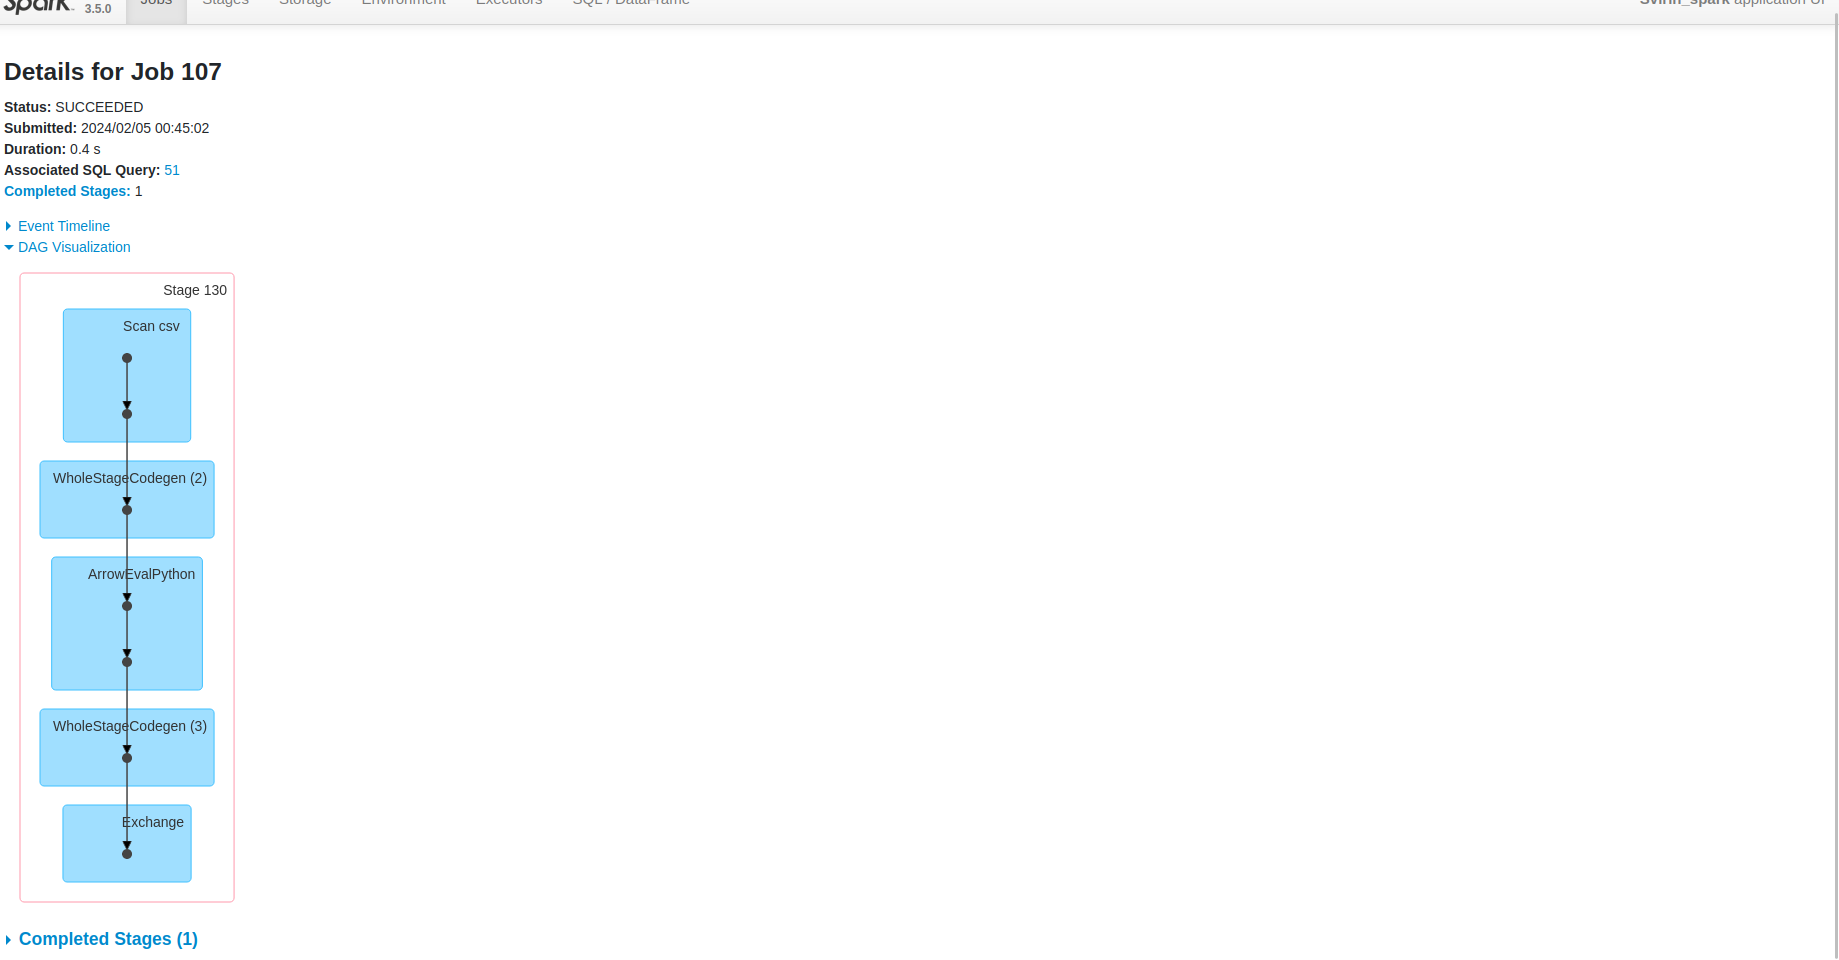

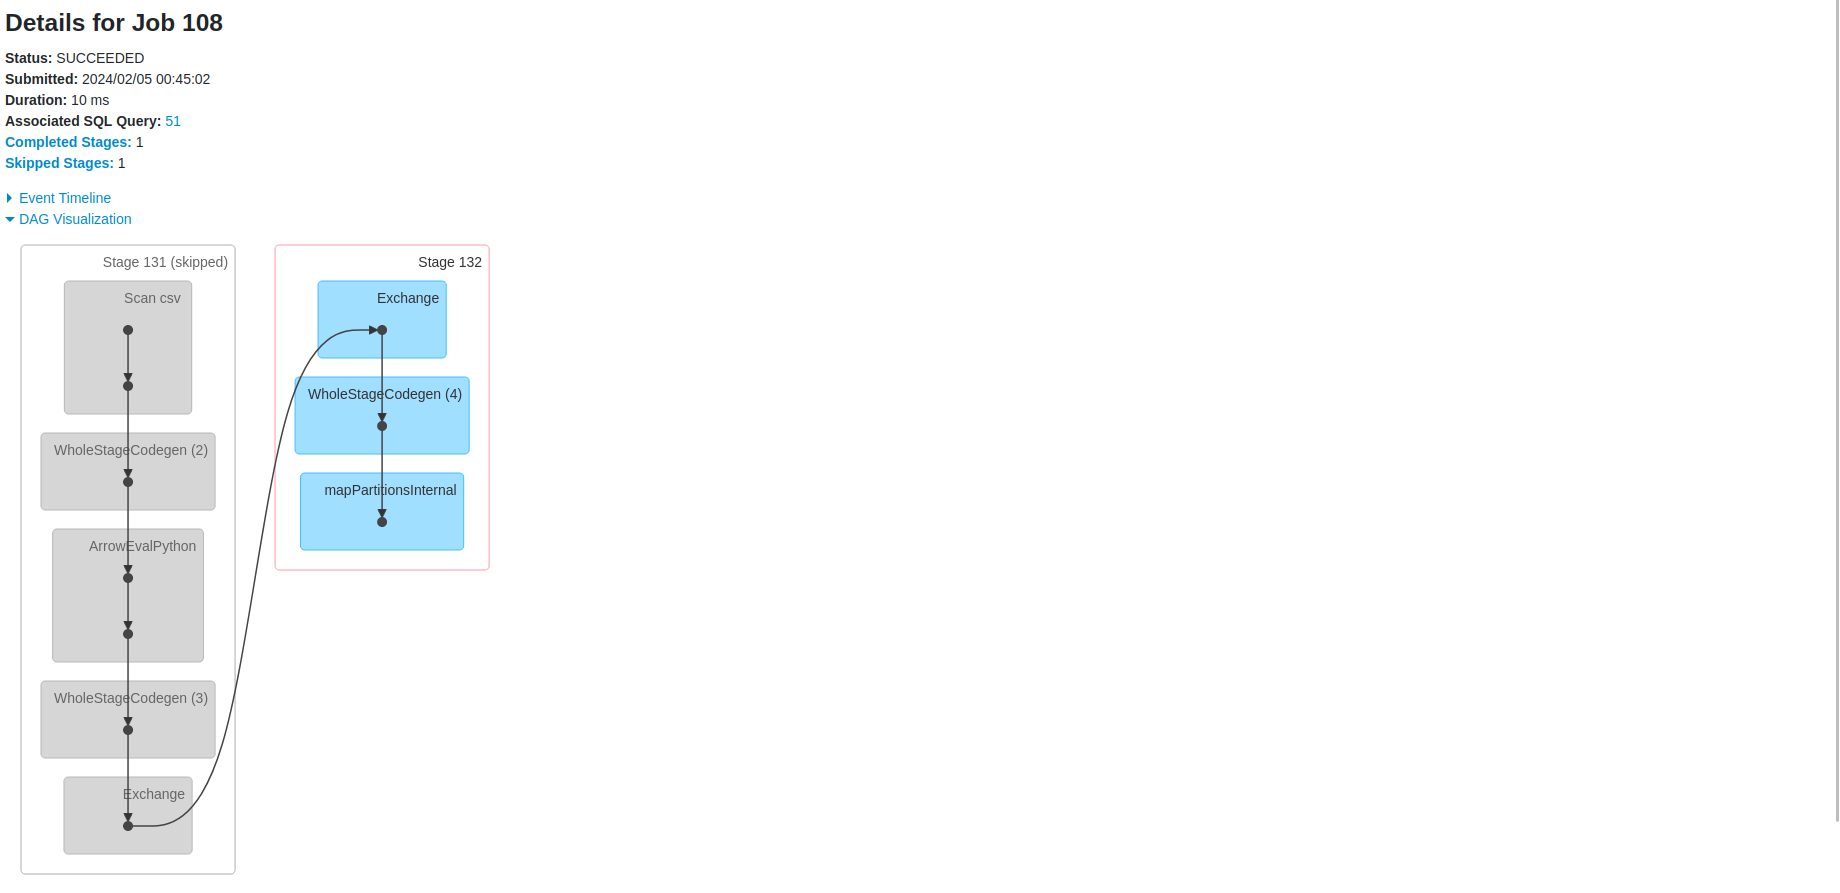

In [ ]:
3 джобы, 2 стейджа